# Exercise Sheet 3

## Exercise 1: Shapley Values

In [1]:
import numpy as np
import math

In [2]:
np.random.seed(123456)

In [3]:
def payoff(team):
    team = set(team)
    t = 't' in team
    s = 's' in team
    m = 'm' in team
    j = 'j' in team
    l = 'l' in team
    reward = 10*t + 10*m + 2*j + 20 * (t and m) + 20 * (t and m and s) - 30 * ((t or m or s) and j)
    return reward

In [4]:
population = ['t', 'm', 's', 'j', 'l']

In [5]:
def all_unique_subsets(population):
    population = list(population)
    if len(population) == 0:
        return [[]]
    else:
        subsets = all_unique_subsets(population[1:])
        subsets_with = []
        for s in subsets:
            s_with = list(s)
            s_with.append(population[0])
            subsets_with.append(s_with)
        subsets = subsets + subsets_with
        return subsets

def shapley(member, population, vfunc):
    remainder = [ind for ind in population if member != ind]
    all_sets = all_unique_subsets(remainder)
    val = 0
    F = len(population)
    for s in all_sets:
        S = len(s)
        diff = vfunc(s + [member]) - vfunc(s)
        factor = math.factorial(S) * math.factorial(F-S-1) / math.factorial(F)
        val += factor * diff
    return val

In [7]:
shapley('t', ['t', 'm', 's', 'j', 'l'], payoff)
shapley('m', ['t', 'm', 's', 'j', 'l'], payoff)
shapley('s', ['t', 'm', 's', 'j', 'l'], payoff)
shapley('l', ['t', 'm', 's', 'j', 'l'], payoff)
shapley('j', ['t', 'm', 's', 'j', 'l'], payoff)

-20.500000000000004

## b)

In [22]:
def shapley_perm(member, population, vfunc, *args, its=100):
    vals = []
    for ii in range(its):
        perm = np.random.permutation(population)
        member_ix = np.where(perm == member)
        s = perm[:member_ix[0][0]].tolist()
        diff = vfunc(s + [member], *args) - vfunc(s, *args)
        vals.append(diff)
    val = sum(vals)/len(vals)
    return val

In [11]:
shapley_perm('t', ['t', 'm', 's', 'j', 'l'], payoff, its=100000)

24.0839

## c) 

### i) Symmetry Check

In [ ]:
def symmetry_check(j, k, population, vfunc, shapley_func):
    remainder = set(population) - set([j, k])
    all_S = all_unique_subsets(remainder)
    surpluss_j = []
    surpluss_k = []
    for S in all_S:
        surplus_j = vfunc(S + [j]) - vfunc(S)
        surplus_k = vfunc(S + [k]) - vfunc(S)
        surpluss_j.append(surplus_j)
        surpluss_k.append(surplus_k)
    surpluss_j, surpluss_k = np.array(surpluss_j), np.array(surpluss_k)
    equal_surplus = np.all(surpluss_j == surpluss_k)
    if equal_surplus:
        print('equal surplus')
        val_j = shapley_func(j, population, vfunc)
        val_k = shapley_func(k, population, vfunc)
        return val_j == val_k
    else:
        return True


In [ ]:
symmetry_check('m', 't', population, payoff, shapley)

### ii) Dummy property check

In [ ]:
def dummy_check(j, population, vfunc, shapley_func):
    remainder = set(population) - set([j])
    all_S = all_unique_subsets(remainder)
    surpluss_j = []
    for S in all_S:
        surplus_j = vfunc(S + [j]) - vfunc(S)
        surpluss_j.append(surplus_j)
    has_contribution = np.sum(np.abs(surpluss_j)) > 0
    if has_contribution:
        print('has contribution')
        val_j = shapley_func(j, population, vfunc)
        return val_j > 0
    else:
        return True

In [ ]:
dummy_check('l', population, payoff, shapley)

### iii) Additivity check

In [ ]:
def additivity_check(population, vfunc1, vfunc2, shapley_func):
    combined = lambda x : vfunc1(x) + vfunc2(x)
    vals1 = np.array([shapley_func(j, population, vfunc1) for j in population])
    vals2 = np.array([shapley_func(j, population, vfunc2) for j in population])
    vals_comb = np.array([shapley_func(j, population, combined) for j in population])
    vals_additive = vals1 + vals2
    return np.all(vals_comb == vals_additive)


In [ ]:
payoff2 = payoff

additivity_check(population, payoff, payoff2, shapley)

### iv): Efficiency check

In [ ]:
def efficiency_check(population, vfunc, shapley_func):
    payoff_total = vfunc(population)
    shapley_vals = [shapley_func(j, population, vfunc) for j in population]
    total_shapley_vals = np.sum(shapley_vals)
    pt, st = round(payoff_total, 5), round(total_shapley_vals, 5)
    return pt == st

In [ ]:
efficiency_check(population, payoff, shapley)

## Exercise 2: SHAP

In [1]:
!pip install shap

In [2]:
import numpy as np
%matplotlib inline

In [3]:
np.random.seed(123456)


### a)

In [4]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv('fifa.csv')
X, y = df.loc[:, df.columns != 'Man of the Match'], df['Man of the Match']
y = y == 'Yes'
X = X.select_dtypes([np.number]).copy()
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [19]:
print(X_test.shape)
print(rf.predict(X_test.iloc[1:2]))
print(rf.predict(X_test.iloc[1:10]))

(39, 18)
[False]
[False False  True  True  True False False False False]


### b) marginal sampling based SHAP value function

In [28]:
def m_vfunc(J, obs, X, predict, nr_samples=100):
    remainder = set(X.columns) - set(J)
    X_tmp = X.sample(nr_samples, replace=True).copy()
    obs_df = pd.DataFrame(obs).T.sample(nr_samples, replace=True)
    obs_df = obs_df.reset_index(drop=True)
    X_tmp.loc[:, J] = np.array(obs_df.loc[:, J].copy())
    pred = predict(X_tmp)
    return np.mean(pred)

In [30]:
shapley_perm(X_test.columns[0], X_test.columns, m_vfunc, X_test.iloc[0,:], X_test, rf.predict)

-0.0167

### c)

In [31]:
from scipy.special import comb
from sklearn.linear_model import LinearRegression
import pandas as pd

def shap_weights(mask):
    p = mask.shape[1]
    zs = np.sum(mask, axis=1)
    nominator = (p - 1)
    denominator = comb(p, zs) * zs * (p - zs)
    return nominator / denominator
    
def replace_dataset(obs, X, nr_samples):
    X_new = np.array(X.sample(nr_samples, replace=True))
    obs_rep = np.repeat(np.array(obs).reshape(-1, 1), X_new.shape[0], axis=1).T
    mask = np.random.binomial(1, 0.5, np.prod(X_new.shape)).reshape(X_new.shape)
    row_ixs, col_ixs = np.where(mask)
    X_new[row_ixs, col_ixs] = obs_rep[row_ixs, col_ixs]
    X_new = pd.DataFrame(X_new, columns=X.columns)
    return X_new, mask

def shap_data(obs, X, nr_samples, predict):
    X_new, mask = replace_dataset(obs, X, nr_samples)
    weight = shap_weights(mask)
    pred = predict(X_new)
    return mask, pred, weight

def kernel_shap(obs, X, nr_samples, predict):
    mask, pred, weight = shap_data(obs, X, nr_samples, predict)
    lm = LinearRegression()
    lm.fit(mask, pred, weight)
    coef = lm.coef_
    coef = pd.Series(coef, index=X.columns)
    coef['intercept'] = lm.intercept_
    return coef

### d)

In [34]:
predict = lambda x : rf.predict_proba(x)[:, 1]

shap_vals = kernel_shap(X_test.iloc[0, :], X, 1000, predict)
print(shap_vals)

Goal Scored               0.058012
Ball Possession %        -0.031624
Attempts                 -0.056860
On-Target                 0.002838
Off-Target                0.020572
Blocked                  -0.009944
Corners                  -0.067219
Offsides                  0.026846
Free Kicks               -0.027515
Saves                    -0.008368
Pass Accuracy %          -0.000142
Passes                   -0.067944
Distance Covered (Kms)    0.016557
Fouls Committed           0.032500
Yellow Card               0.042642
Yellow & Red             -0.056101
Red                      -0.009925
Goals in PSO              0.024113
intercept                 0.502887
dtype: float64


### e)

`SHAP` values are expensive to compute. `TreeSHAP` offers a more efficient implementation that exploits the structure of tree-based models. Advanced knowledge: A further advantage of TreeSHAP is that it resamples the variables such that the joint distribution is preserved.

/home/coco/anaconda3/envs/devel/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


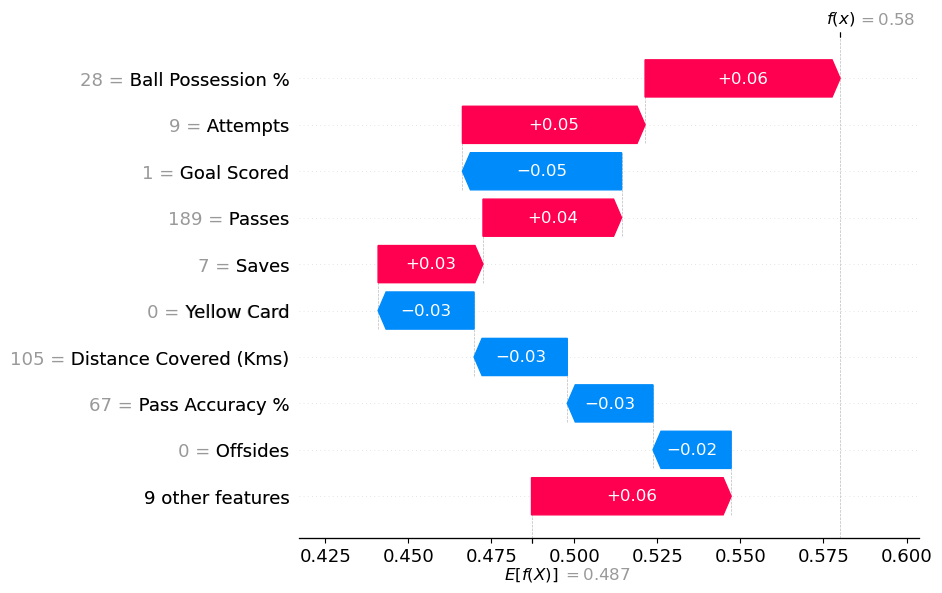

In [15]:
import shap

explainer = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0][:, 0])

Distance covered had a strong positive effect on the predicted probability, whereas the number of free kicks, the number of off-target shots and the number of goals had a negative effect. 

## Exercise 3: Lime

In [ ]:
!pip install lime

In [ ]:
import numpy as np
%matplotlib inline

In [ ]:
np.random.seed(123456)

### a)

In [ ]:
import lime.lime_tabular
import lime

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_test), feature_names=X.columns, class_names=rf.classes_)

exp = explainer.explain_instance(np.array(X_test.iloc[0, :]), rf.predict_proba, num_features=5, top_labels=1,
                                 distance_metric='l2')
exp.show_in_notebook(show_table=True, show_all=False)

### b)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_test), feature_names=X.columns,
                                                   class_names=rf.classes_, kernel_width=3.0)

exp = explainer.explain_instance(np.array(X_test.iloc[0, :]), rf.predict_proba, num_features=5, top_labels=1,
                                 distance_metric='l1')
exp.show_in_notebook(show_table=True, show_all=False)

The results depend on the used metric to define the neighborhood.

### c)

Both SHAP and Lime rely on a linear model approximation of the model. For lime, the normal feature values are used, for SHAP a transformed distribution indicating coalition membership for a sample is relied upon. Lime weights the different samples according to their distance to the observation of interest. In contrast, SHAP weights them according to the shapley kernel weights (which simulate sampling random permutations).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=465b8883-1966-407a-bc10-026a1a84551f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>